### Content based Jokes recommendation system using topic modelling apporach !!
------------------------------------------------------------------------

    Topic modelling is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. We will try to find topic of the joke which can be used as the joke tag !

In [1]:
# Necessary imports !
import nltk
import sqlite3 as db
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# loading data from sql database
database = 'data/jester_jokes.db'
conn = db.connect(database)

query = 'SELECT * FROM jokes'
jokes = pd.read_sql(query, conn)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('jokes',), ('ratings',), ('normalized_ratings',)]


    Looking at jokes raw data !

In [2]:
jokes.head(5)

,joke_id,joke
0,1,"\nA man visits the doctor. The doctor says ""..."
1,10,"| \n\n \nTwo cannibals are eating a clown, o..."
2,100,\n \nQ: Whats the difference between greeti...
3,11,"| \n\n \nQ. What do a hurricane, a tornado, ..."
4,12,| \n\n \nA guy stood over his tee shot for w...


Since raw data is very dirty, we will first clean the data. The basic cleaning will involve following steps !!

##### Text cleaning steps:

    a. Convert to lowercase, 
    b. Keep only alphanumeric characters and space, 
    c. Replace anything else with whitespace, 
    d. Strip extra white spaces

In [3]:
import re

def cleanText(text):
    text = text.lower()
    text = re.sub(r'[^\w+\s]', ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.strip()
    return text

# save the cleaned data into a new column named cleanedText1 
jokes['cleanedText1'] = jokes['joke'].apply(lambda x: cleanText(x))
jokes.head()

,joke_id,joke,cleanedText1
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...
2,100,\n \nQ: Whats the difference between greeti...,q whats the difference between greeting a quee...
3,11,"| \n\n \nQ. What do a hurricane, a tornado, ...",q what do a hurricane a tornado and a redneck ...
4,12,| \n\n \nA guy stood over his tee shot for w...,a guy stood over his tee shot for what seemed ...


### Remove stopwords
    We will filter out most common words, which are neutral and doesn't imply any category!

##### One way to use stop word is by using nltk stopwords, but we will be using stopwords based in the jokes text
    '''
    from nltk.corpus import stopwords  
    stopwords = list(set(stopwords.words('english')))
    '''


In [4]:
stopwords = ["---","---|---","i", "me", "my", "myself", "we",
             "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself",
             "she", "her", "hers", "herself", "it", "its", "itself",
             "they", "them", "their", "theirs", "themselves", "what",
             "which", "who", "whom", "this", "that", "these", "those",
             "am", "is", "are", "was", "were", "be", "been", "being",
             "have", "has", "had", "having", "do", "does", "did", "doing",
             "a", "an", "the", "and", "but", "if", "or", "because", "as",
             "until", "while", "of", "at", "by", "for", "with", "about",
             "against", "between", "into", "through", "during", "before",
             "after", "above", "below", "to", "from", "up", "down", "in",
             "out", "on", "off", "over", "under", "again", "further", "then",
             "once", "here", "there", "when", "where", "why", "how", "all",
             "any", "both", "each", "few", "more", "most", "other", "some",
             "such", "no", "nor", "not", "only", "own", "same", "so", "than",
             "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def removeStopwords(text):
    words = text.split(' ')
    new_words = []
    for w in words:
        if w in stopwords:
            pass
        else:
            new_words.append(w)
    return ' '.join(new_words)
    
# saving into new column as clearText2
jokes['cleanedText2'] = jokes['cleanedText1'].apply(lambda x: removeStopwords(x))
jokes.head()

,joke_id,joke,cleanedText1,cleanedText2
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...
2,100,\n \nQ: Whats the difference between greeti...,q whats the difference between greeting a quee...,q whats difference greeting queen greeting pre...
3,11,"| \n\n \nQ. What do a hurricane, a tornado, ...",q what do a hurricane a tornado and a redneck ...,q hurricane tornado redneck divorce common som...
4,12,| \n\n \nA guy stood over his tee shot for w...,a guy stood over his tee shot for what seemed ...,guy stood tee shot seemed eternity looking loo...


### Lemmetization
We will group together the inflected forms of a word so they can be analysed as a single item

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
  
print("rocks :", lemmatizer.lemmatize("rocks")) 
print("corpora :", lemmatizer.lemmatize("corpora")) 
  
# a denotes adjective in "pos" 
print("better :", lemmatizer.lemmatize("better", pos ="a"))

# v denotes verb in "pos" and n denotes noun 
print("greeting :", lemmatizer.lemmatize("greeting", pos ="v"))
print("greeting :", lemmatizer.lemmatize("greeting", pos ="n"))

rocks : rock
corpora : corpus
better : good
greeting : greet
greeting : greeting


    In the above two examples, first greeting is verb so after Lemmetization it become greet, another greeting is noun so even after Lemmetization it remains same
    
##### Performing Lemmetization over entire jokes!

In [6]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
   
lemmatizer = WordNetLemmatizer() 
   
def performLemmatization(text):
    words = word_tokenize(text)
    new_words=[]
    
    for w in words:
        new_words.append(lemmatizer.lemmatize(w))
        
    return ' '.join(new_words)

# saving into cleanedText3
jokes['cleanedText3'] = jokes['cleanedText2'].apply(lambda x: performLemmatization(x))
jokes.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...


### Part Of Speech tagging or PoS Tagging !
    We will separate each word any try to find out their parts of speech!

In [7]:
from nltk import word_tokenize, pos_tag

def posTagging(text):
    text = nltk.word_tokenize(text)
    return pos_tag(text, tagset='universal')

# saving in new column as 'pos_tags'
jokes['pos_tags'] = jokes['cleanedText2'].apply(lambda x: posTagging(x))
jokes.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3,pos_tags
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...,"[(man, NOUN), (visits, NOUN), (doctor, VERB), ..."
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...,"[(two, NUM), (cannibals, NOUN), (eating, VERB)..."


    pos_tags are in list from, so we will separate it in all forms of part of speech

In [8]:
pd.options.mode.chained_assignment = None

jokes['ADJ'] = pd.Series(dtype=str)
jokes['ADP'] = pd.Series(dtype=str)
jokes['ADV'] = pd.Series(dtype=str)
jokes['CONJ'] = pd.Series(dtype=str)
jokes['DET'] = pd.Series(dtype=str)
jokes['NOUN'] = pd.Series(dtype=str)
jokes['NUM'] = pd.Series(dtype=str)
jokes['PRT'] = pd.Series(dtype=str)
jokes['PRON'] = pd.Series(dtype=str)
jokes['PRT'] = pd.Series(dtype=str)
jokes['PRON'] = pd.Series(dtype=str)
jokes['VERB'] = pd.Series(dtype=str)
jokes['PUNC'] = pd.Series(dtype=str)
jokes['OTHERS'] = pd.Series(dtype=str)


for i in range(len(jokes)):

    pos_tags = jokes['pos_tags'][i]

    ADJ = []
    ADP = []
    ADV = []
    CONJ = []
    DET = []
    NOUN = []
    NUM = []
    PRT = []
    PRON = []
    VERB = []
    PUNC = []
    OTHERS = []

    for tag in pos_tags:
        if tag[1] == 'ADJ':
            ADJ.append(tag[0])
        if tag[1] == 'ADP':
            ADP.append(tag[0])
        if tag[1] == 'ADV':
            ADV.append(tag[0])
        if tag[1] == 'CONJ':
            CONJ.append(tag[0])
        if tag[1] == 'DET':
            DET.append(tag[0])
        if tag[1] == 'NOUN':
            NOUN.append(tag[0])
        if tag[1] == 'NUM':
            NUM.append(tag[0])
        if tag[1] == 'PRT':
            PRT.append(tag[0])
        if tag[1] == 'PRON':
            PRON.append(tag[0])
        if tag[1] == 'VERB':
            VERB.append(tag[0])
        if tag[1] == '.':
            PUNC.append(tag[0])
        if tag[1] == 'X':
            OTHERS.append(tag[0])

    jokes['ADJ'][i] = ADJ
    jokes['ADP'][i] = ADP
    jokes['ADV'][i] = ADV
    jokes['CONJ'][i] = CONJ
    jokes['DET'][i] = DET
    jokes['NOUN'][i] = NOUN
    jokes['NUM'][i] = NUM
    jokes['PRT'][i] = PRT
    jokes['PRON'][i] = PRON
    jokes['PRT'][i] = PRT
    jokes['PRON'][i] = PRON
    jokes['VERB'][i] = VERB
    jokes['PUNC'][i] = PUNC
    jokes['OTHERS'][i] = OTHERS

# saving the data into csv format for later use !
jokes.to_csv('data/jokes_postags.csv', index=False)
jokes.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3,pos_tags,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,PUNC,OTHERS
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...,"[(man, NOUN), (visits, NOUN), (doctor, VERB), ...","[bad, thank]",[],[well],[],[],"[man, visits, doctor, news, cancer, alzheimer,...",[],[],[],"[doctor, says, replies]",[],[]
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...,"[(two, NUM), (cannibals, NOUN), (eating, VERB)...",[clown],[],[],[],[],"[cannibals, taste, funny]","[two, one]",[],[],"[eating, turns, says]",[],[]


## Count of POS tags

In [9]:
jokes_postags = pd.read_csv('data/jokes_postags.csv')

ADJ = []
ADP = []
ADV = []
CONJ = []
DET = []
NOUN = []
NUM = []
PRT = []
PRON = []
VERB = []
PUNC = []
OTHERS = []

for i in range(len(jokes_postags)):
    ADJ.extend(jokes['ADJ'][i])
    ADP.extend(jokes['ADP'][i])
    ADV.extend(jokes['ADV'][i])
    CONJ.extend(jokes['CONJ'][i])
    DET.extend(jokes['DET'][i])
    NOUN.extend(jokes['NOUN'][i])
    NUM.extend(jokes['NUM'][i])
    PRT.extend(jokes['PRT'][i])
    PRON.extend(jokes['PRON'][i])
    PRT.extend(jokes['PRT'][i]) 
    PRON.extend(jokes['PRON'][i])
    VERB.extend(jokes['VERB'][i]) 
    PUNC.extend(jokes['PUNC'][i]) 
    OTHERS.extend(jokes['OTHERS'][i])

print("ADJ: "+str(len(ADJ)))
print("ADP: "+str(len(ADP)))
print("ADV: "+str(len(ADV)))
print("CONJ: "+str(len(CONJ)))
print("DET: "+str(len(DET)))
print("NOUN: "+str(len(NOUN)))
print("NUM: "+str(len(NUM)))
print("PRT: "+str(len(PRT)))
print("PRON: "+str(len(PRON)))
print("VERB: "+str(len(VERB)))
print("PUNC: "+str(len(PUNC)))
print("OTHERS: "+str(len(OTHERS)))

ADJ: 494
ADP: 39
ADV: 168
CONJ: 0
DET: 18
NOUN: 1463
NUM: 140
PRT: 4
PRON: 16
VERB: 766
PUNC: 1
OTHERS: 5


### Filter by POS tag, length of word should be greater than 1 and they belong to noun and verb only !!

In [10]:
jokes1 = pd.read_csv('data/jokes_postags.csv')

In [11]:
import ast

def filterByPOS(tags):
    txt = []
    tags = tags[1:len(txt)-1]
    tags = ast.literal_eval(tags)
    for t in tags:
        if t[1] in ['NOUN', 'VERB'] and len(t[0])>1:
            txt.append(t[0])
            
    return ' '.join(txt)

jokes1['cleanedText4'] = jokes1['pos_tags'].apply(lambda x: filterByPOS(x))
jokes1.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3,pos_tags,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,PUNC,OTHERS,cleanedText4
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...,"[('man', 'NOUN'), ('visits', 'NOUN'), ('doctor...","['bad', 'thank']",[],['well'],[],[],"['man', 'visits', 'doctor', 'news', 'cancer', ...",[],[],[],"['doctor', 'says', 'replies']",[],[],man visits doctor doctor says news cancer alzh...
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...,"[('two', 'NUM'), ('cannibals', 'NOUN'), ('eati...",['clown'],[],[],[],[],"['cannibals', 'taste', 'funny']","['two', 'one']",[],[],"['eating', 'turns', 'says']",[],[],cannibals eating turns says taste funny


In [12]:
# saving the data into csv file
jokes1.to_csv("data/jokes_postags_filtered.csv", index = False)

# Topic Modelling with LDA

    latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

In [13]:
docs = jokes1['cleanedText4'].tolist()

In [14]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

docs = [d.split() for d in docs]

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [15]:
print(dictionary)

Dictionary(1102 unique tokens: ['alzheimer', 'cancer', 'disease', 'doctor', 'god']...)


In [16]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [17]:
top_topics = model.top_topics(corpus) #, num_words=20)

from pprint import pprint
pprint(top_topics)

[([(0.026647301, 'said'),
   (0.023817781, 'would'),
   (0.017108733, 'house'),
   (0.017108386, 'get'),
   (0.013756157, 'engineer'),
   (0.013752768, 'time'),
   (0.013750262, 'guess'),
   (0.010399552, 'died'),
   (0.010399382, 'asks'),
   (0.010398618, 'bed'),
   (0.010395802, 'used'),
   (0.010394557, 'shook'),
   (0.010391887, 'head'),
   (0.010364236, 'going'),
   (0.007187417, 'says'),
   (0.007045757, 'seated'),
   (0.007045757, 'take'),
   (0.007045757, 'll'),
   (0.007045757, 'look'),
   (0.007045757, 'began')],
  -11.903535654848776),
 ([(0.022964284, 'says'),
   (0.013340671, 'make'),
   (0.010086814, 'call'),
   (0.010086814, 'builder'),
   (0.010086813, 'guy'),
   (0.010086812, 'languages'),
   (0.0100848405, 'girl'),
   (0.010082304, 'married'),
   (0.010081645, 'dad'),
   (0.010081515, 'william'),
   (0.010080126, 'news'),
   (0.0073465854, 'said'),
   (0.0068329484, 'built'),
   (0.0068329484, 'road'),
   (0.0068329484, 'see'),
   (0.0068329484, 'pier'),
   (0.0068329

In [18]:
#save trained model for future use
model.save("model/lda.model")

### Get topic assignment for each document
### Column 'cluster' containes the probability of belonging to each topic

In [19]:
docs = jokes1['cleanedText4'].tolist()

cluster = []

for d in docs:
    bow = dictionary.doc2bow(d.split())
    topics = model.get_document_topics(bow, minimum_probability = 0.0)
    cluster.append(topics)
    
jokes1['cluster'] = pd.Series(cluster)

In [20]:
jokes1.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3,pos_tags,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,PUNC,OTHERS,cleanedText4,cluster
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...,"[('man', 'NOUN'), ('visits', 'NOUN'), ('doctor...","['bad', 'thank']",[],['well'],[],[],"['man', 'visits', 'doctor', 'news', 'cancer', ...",[],[],[],"['doctor', 'says', 'replies']",[],[],man visits doctor doctor says news cancer alzh...,"[(0, 0.002828441), (1, 0.0024506196), (2, 0.00..."
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...,"[('two', 'NUM'), ('cannibals', 'NOUN'), ('eati...",['clown'],[],[],[],[],"['cannibals', 'taste', 'funny']","['two', 'one']",[],[],"['eating', 'turns', 'says']",[],[],cannibals eating turns says taste funny,"[(0, 0.005954403), (1, 0.0051590176), (2, 0.00..."


In [21]:
jokes1.to_csv("data/jokes_topic_probabilities.csv", index=False)

### Sort topics by probabilities

In [22]:
from operator import itemgetter

sorted_topics = []

for i in range(len(jokes)):
    sorted_topics.append(sorted(jokes1['cluster'][i],key=itemgetter(1),  reverse=True))
    
jokes1['sorted_topics'] = pd.Series(sorted_topics)
jokes1.head()

jokes1.to_csv("data/jokes_sorted_topic.csv", index=False)

### Get the topic with maximum probability

In [23]:
maximum_probability_topic = []
for i in range(len(jokes)):
    maximum_probability_topic.append(jokes1['sorted_topics'][i][0][0])

jokes1['main_topic'] = maximum_probability_topic
jokes1.to_csv("data/jokes_sorted_topic.csv", index=False)

In [24]:
jokes1.head(2)

,joke_id,joke,cleanedText1,cleanedText2,cleanedText3,pos_tags,ADJ,ADP,ADV,CONJ,...,NUM,PRT,PRON,VERB,PUNC,OTHERS,cleanedText4,cluster,sorted_topics,main_topic
0,1,"\nA man visits the doctor. The doctor says ""...",a man visits the doctor the doctor says i have...,man visits doctor doctor says bad news cancer ...,man visit doctor doctor say bad news cancer al...,"[('man', 'NOUN'), ('visits', 'NOUN'), ('doctor...","['bad', 'thank']",[],['well'],[],...,[],[],[],"['doctor', 'says', 'replies']",[],[],man visits doctor doctor says news cancer alzh...,"[(0, 0.002828441), (1, 0.0024506196), (2, 0.00...","[(9, 0.9770882), (6, 0.0033219575), (2, 0.0028...",9
1,10,"| \n\n \nTwo cannibals are eating a clown, o...",two cannibals are eating a clown one turns to ...,two cannibals eating clown one turns says tast...,two cannibal eating clown one turn say taste f...,"[('two', 'NUM'), ('cannibals', 'NOUN'), ('eati...",['clown'],[],[],[],...,"['two', 'one']",[],[],"['eating', 'turns', 'says']",[],[],cannibals eating turns says taste funny,"[(0, 0.005954403), (1, 0.0051590176), (2, 0.00...","[(8, 0.95312816), (6, 0.0069933482), (2, 0.006...",8


### Count plot of number of jokes per topic

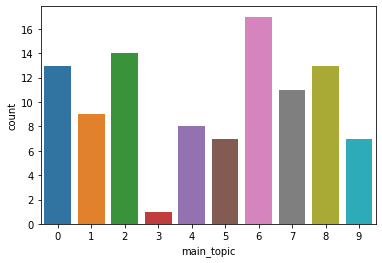

In [25]:
jokes_topic = pd.read_csv("data/jokes_sorted_topic.csv")
jokes_topic.head()

sns.countplot(x = 'main_topic',
            data = jokes_topic)
plt.show()

# Normalize User Ratings

In [26]:
query = 'SELECT * FROM ratings'
ratings = pd.read_sql(query, conn)

In [27]:
ratings.head()

,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
0,1,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,2,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,4,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,5,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [28]:
#Replace 99 with NaN
ratings.replace(99.0, np.nan, inplace=True)
ratings.head()

,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
0,1.0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,2.0,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3.0,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


### Find Deviation from mean for each user

In [29]:
ratings1 = ratings.iloc[:, 2:102]
ratings1['mean_rating'] = ratings1.mean(axis=1)
ratings1['std_dev'] = ratings1.std(axis=1)

for i in range(100):
    ratings1[ratings1.columns[i]] = (ratings1[ratings1.columns[i]] - ratings1['mean_rating'])/ratings1['std_dev']
    
ratings1.head()

ratings1.to_csv('data/ratings_standardscalar.csv', index = False)

### Normalize between -1 and 1 with Robust Scaling

In [ ]:
ratings1 = ratings.iloc[:, 2:102]
ratings1['quantile1'] = ratings1.quantile(q=0.25, axis=1)
ratings1['quantile3'] = ratings1.quantile(q=0.75, axis=1)

for i in range(100):
    ratings1[ratings1.columns[i]] = (ratings1[ratings1.columns[i]]-ratings1['quantile1'])/(ratings1['quantile3']-ratings1['quantile1'])


ratings1['user_id'] = ratings.iloc[:,0]    
ratings1['number_of_jokes_rated'] = ratings.iloc[:,1] 
ratings1.to_csv('data/ratings_robustcalar.csv', index = False)

In [ ]:
ratings1.head()

# Per user stable topics 

In [ ]:
jokes = pd.read_csv("data/jokes_sorted_topic.csv")

In [ ]:
#Get joke_id and topic with max probability
jokes_topic = jokes[['joke_id','main_topic']]

In [ ]:
ratings = pd.read_csv('data/ratings_robustcalar.csv')

In [ ]:
#Get user's rating for each joke_id

jokes_rating = pd.DataFrame()
jokes_ids = list(range(1,101))
user_rating = []

#Hard-coded for user_id 0. Need for loop here
user_id = 1
for i in range(100):
    user_rating.append(ratings.iloc[user_id,i])

jokes_rating['joke_id']= pd.Series(jokes_ids)
jokes_rating['rating'] = pd.Series(user_rating)

In [ ]:
user_ratings = pd.merge(jokes_rating,jokes_topic,on='joke_id')

#Sort user ratings in descending order
user_ratings.sort_values(by=['rating'],ascending=False, inplace=True)

In [ ]:
#Print user's rating sorted in descending
user_ratings.head()

# Recommend joke to user

### Select an active user and his ratings

In [ ]:
#Read normalized ratings
ratings = pd.read_csv('data/ratings_robustcalar.csv')
ratings.head()

In [ ]:
#Select users with less than 100 ratings
ratings_not100 = ratings[ratings['number_of_jokes_rated']<100]
print(len(ratings_not100))

In [ ]:
#Randomly select an active user
from random import sample 

user_ids = list(ratings_not100['user_id'])
active_user = sample(user_ids,1)[0]
active_user

In [ ]:
#Get active user's rating for each joke_id
active_user_ratings = ratings_not100[ratings_not100['user_id']==active_user]
active_user_ratings

In [ ]:
jokes_rating = pd.DataFrame()
jokes_ids = list(range(1,101))
user_rating = []

for i in range(100):
    user_rating.append(active_user_ratings.iloc[0,i])

jokes_rating['joke_id']= pd.Series(jokes_ids)
jokes_rating['rating'] = pd.Series(user_rating)

#Print active user's rating for each joke
jokes_rating.head()

In [ ]:
#join jokes_rating and topics

jokes = pd.read_csv("data/jokes_sorted_topic.csv")
jokes_topic = jokes[['joke_id','main_topic']]

active_user_ratings = pd.merge(jokes_rating,jokes_topic,on='joke_id')

#Sort user ratings in descending order
active_user_ratings.sort_values(by=['rating'],ascending=False, inplace=True)

#Print user's rating sorted in descending
active_user_ratings.head()

### Recommend joke to user based on highly rated topics

In [ ]:
#Distribution of active users ratings

sns.distplot(active_user_ratings['rating'], kde = False)
plt.show()

In [ ]:
#Selecting topics with ratings greater than 0.8

interested_topics = active_user_ratings[active_user_ratings['rating']>0.8]
interested_topics = set(interested_topics['main_topic'])
interested_topics

In [ ]:
#Randomly select 3 interested topics

from random import sample 

random_interested_topics = sample(interested_topics,3)
random_interested_topics

In [ ]:
#Select the jokes belonging to interested topic

jokes2 = pd.read_csv("data/jokes_sorted_topic.csv")

selected_joke_ids = []

for i in range(len(jokes2)):
    if jokes2.iloc[i]['main_topic'] in random_interested_topics:
        selected_joke_ids.append(jokes2.iloc[i]['joke_id'])

#Number of jokes belonging to interested topic
print(len(selected_joke_ids))

In [ ]:
#Select not rated jokes from interested topics
jokes_unrated = active_user_ratings[active_user_ratings['rating'].isnull()]
unrated_and_interested = jokes_unrated[jokes_unrated['main_topic'].isin(random_interested_topics)]
unrated_and_interested.head()

In [ ]:
#Randomly select a joke to recommend
unrated_and_interested.sample()

# Evaluation of Recommendation

In [ ]:
#Recommend a joke only from the rated jokes for evalaluation only
jokes_rated = active_user_ratings[active_user_ratings['rating'].notnull()]
rated_and_interested = jokes_rated[jokes_rated['main_topic'].isin(random_interested_topics)]
rated_and_interested.head()

In [ ]:
#Randomly select a joke to recommend
recommeded_joke = rated_and_interested.sample()
recommeded_joke

In [ ]:
#Select all jokes rated by the user for training data
jokes_filtered = pd.read_csv("data/jokes_postags_filtered.csv")
jokes_data = pd.merge(jokes_rated,jokes_filtered,on='joke_id')
jokes_data = jokes_data[['joke_id','rating','cleanedText4']]
jokes_data.head()

### Train a model to predict the ratings for the active user

In [ ]:
#Train model to predict rating from tf-idf
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import  RandomForestRegressor

from sklearn.model_selection import train_test_split

pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestRegressor(max_depth=10))
])

X = jokes_data['cleanedText4']
Y = jokes_data['rating']

review_train, review_test, label_train, label_test = train_test_split(X, Y, test_size=0.2)
pipeline.fit(review_train, label_train)

### Predict rating of recommended joke

In [ ]:
jid = recommeded_joke['joke_id'].iloc[0]
text_data = jokes_data[jokes_data['joke_id']==jid]
pip_pred = pipeline.predict(text_data['cleanedText4'])
pip_pred

### Calculate the prediction error

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(text_data['rating'], pip_pred, squared=False)

--------------------------------------------------------
                                    END

-----------------------------------------------------------------